# Week 9 - Neural Networks

Neural networks are the latest *big thing* and work best with lots of data. There are many, many ways to interact with neural networks in Python, including `tensorflow`, `pytorch`, `keras` (a tensorflow API), `theano` and more. All of these do functionally the same thing, but with varying degrees of needing more/less code at the tradeoff of having less/more control over what the model is doing.

We will be using the `keras` framework to build our models - this is built upon the `tensorflow` framework but gives us more convinient "high level" functions to work with to build and train models quickly and easily.

Let's look at how to build 3 types of models - a simple fully connected model, a recurrent neural network, and a convolutional neural network.


In [ ]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, InputLayer
from tensorflow.keras.utils import to_categorical

# Commonly used modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, f1_score

In [ ]:
print(tf.__version__)

2.5.0


This function will tell us if we have gpu acceleration available.
Colab doesn't, hence we can't do too much deep learning.
Getting GPU acceleration will cost some money (either buying a 
dedicated GPU or renting one from the cloud), so we will try to
work without.



In [ ]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


Let's start with the housing dataset to try and obtain a house price prediction method.

In [ ]:
!wget https://raw.githubusercontent.com/stmball/PracticalPython/main/Numpy%2C%20Pandas%20and%20Scipy/housing.csv

--2021-06-14 18:27:00--  https://raw.githubusercontent.com/stmball/PracticalPython/main/Numpy%2C%20Pandas%20and%20Scipy/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24632 (24K) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]  24.05K  --.-KB/s    in 0.002s  

2021-06-14 18:27:00 (13.4 MB/s) - ‘housing.csv.1’ saved [24632/24632]



Let's import the dataset - we've done this many times now!

In [ ]:
housing = pd.read_csv("./housing.csv", index_col=0)

housing.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


We have a problem here, which we have seen before. Since a nerual network model only accepts numeric inputs, we have to map the yes/no values to 1/0.

In [ ]:
def yes_no_mapper(string):
    if string == "yes":
        return 1
    else:
        return 0

# Apply the above function to the columns we want.
housing[["driveway", "recroom", "fullbase", "gashw", "airco", "prefarea"]] = housing[["driveway", "recroom", "fullbase", "gashw", "airco", "prefarea"]].applymap(yes_no_mapper)

Let's double check the output:

In [ ]:
housing

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,1,0,1,0,0,1,0
2,38500.0,4000,2,1,1,1,0,0,0,0,0,0
3,49500.0,3060,3,1,1,1,0,0,0,0,0,0
4,60500.0,6650,3,1,2,1,1,0,0,0,0,0
5,61000.0,6360,2,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
542,91500.0,4800,3,2,4,1,1,0,0,1,0,0
543,94000.0,6000,3,2,4,1,0,0,0,1,0,0
544,103000.0,6000,3,2,4,1,1,0,0,1,1,0
545,105000.0,6000,3,2,2,1,1,0,0,1,1,0


Neural networks love to have normalised inputs - the type of scaler you use will depend on the inputs you have - finding this will take some experimentation but either MinMax or StandardScaler seem to be the best. Let's scale the data and do some reshaping to make Tensorflow happy. 99% of errors come from shape issues with Tensorflow!

In [ ]:
y = housing['price'].values
y = y.reshape(-1, 1)
x = housing.drop('price', axis=1).values

x_scaler = MinMaxScaler()
x = x_scaler.fit_transform(x)

# It is very common to force it to have one sample per line in this way
x = x.reshape(-1, 1, 11)

y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y)


Now we have our data split into x and y, and somewhat scaled, let's train test split and continue:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape)

(436, 1, 11)


Now let's define a model. Keras has a few ways to do this, depending on how advanced we want to build our model. For now, let's look at the Sequential API; this is the power of Keras - Tensorflow doesn't have syntax this "abstracted"!

In [ ]:
model = keras.Sequential(
    [
        Dense(8, activation='relu', input_shape=(1, 11)),
        Dense(8, activation='relu'),
        Dense(1)
    ]
)

# Two callback functions to control the learning rate of the model. Will be clear
# later!
lr_reduct = tf.keras.callbacks.ReduceLROnPlateau(verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

# Actually compile the model with the optimizer function, loss function, any
# metrics we want to track etc.
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 8)              96        
_________________________________________________________________
dense_4 (Dense)              (None, 1, 8)              72        
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


Now it's time to actually fit our model to the data. There's a lot more hyperparameters to set up here - the `batch_size` dictates how many samples the model should go through before changing the weights of the model. `validation_split` will automatically create a validation dataset that the model will use at the end of each epoch to test for overfitting. Using the callback functions from earlier, the learning rate of the model will decrease if no progress is made in the *validation* dataset, and will stop altogether if still no progress is made after.

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    verbose=1, 
                    batch_size=10, 
                    validation_split=0.2,
                    callbacks=[lr_reduct, early_stopping])

Epoch 1/100
35/35 [==============================] - 1s 8ms/step - loss: 0.0929 - mae: 0.2360 - val_loss: 0.0486 - val_mae: 0.1677
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0422 - mae: 0.1584 - val_loss: 0.0333 - val_mae: 0.1377
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0335 - mae: 0.1412 - val_loss: 0.0269 - val_mae: 0.1217
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0280 - mae: 0.1265 - val_loss: 0.0226 - val_mae: 0.1102
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0241 - mae: 0.1158 - val_loss: 0.0199 - val_mae: 0.1027
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0215 - mae: 0.1063 - val_loss: 0.0178 - val_mae: 0.0962
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0194 - mae: 0.0991 - val_loss: 0.0163 - val_mae: 0.0908
Epoch 8/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0171 - m

Now we have a trained model - but let's do something very common with deep learning and take a look at the historical metrics of our model:

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,mae,val_loss,val_mae,lr
0,0.092914,0.235968,0.048563,0.167736,0.00100
1,0.042183,0.158375,0.033340,0.137716,0.00100
2,0.033502,0.141198,0.026944,0.121729,0.00100
3,0.027968,0.126505,0.022640,0.110169,0.00100
4,0.024097,0.115816,0.019879,0.102747,0.00100
...,...,...,...,...,...
80,0.007862,0.066872,0.010439,0.076231,0.00001
81,0.007861,0.066870,0.010439,0.076230,0.00001
82,0.007862,0.066855,0.010434,0.076206,0.00001
83,0.007861,0.066854,0.010437,0.076218,0.00001


Now let's plot them:

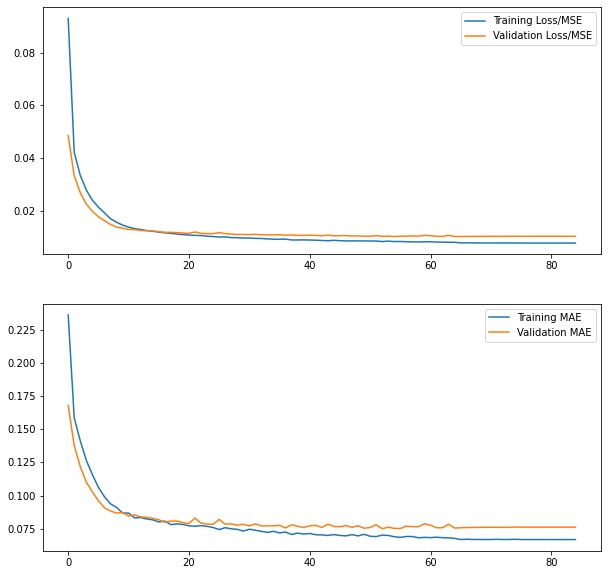

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history_df['loss'], label="Training Loss/MSE")
ax1.plot(history_df['val_loss'], label='Validation Loss/MSE')
ax1.legend()

ax2.plot(history_df['mae'], label="Training MAE")
ax2.plot(history_df['val_mae'], label="Validation MAE")
ax2.legend()

plt.show()


So how do we read these plots? Essentially, the validation metrics are the best reflection of our model's performance, since the training metrics are prone to overfitting. The point at which the validation metrics stop improving is usually a good place to stop training, as everything after is making the model over-specific to the training data.

Let's get a final, interpretable performance metric for our model using our test dataset

In [ ]:
y_predict = model.predict(x_test)

In [ ]:
# Since our data was transformed, we have to transform it back to
# something that makes sense.
y_predict = y_scaler.inverse_transform(y_predict.reshape(-1, 1))
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Here we use mean absolute error to get an intepretable value.
print("RMSE for test dataset:", mean_absolute_error(y_predict, y_test))

RMSE for test dataset: 11846.700337357952


So on average, our model is wrong by about 12000 USD. The mean house price is about 68000 USD, so not awful for a small model!

# Convolutional Neural Networks

CNNs are the current "big thing" in AI, and are typically used from video analysis to studying genomic data. Even though the mechanism by which they work is most like the vision system in many animals, it turns out that same system is quite useful for a lot of other tasks! For now though, let's keep it simple and look at a benchmark dataset, called "Fashion MNIST". `keras` comes with this dataset built in, with everything preprocessed nicely for us, so let's take a look: 

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

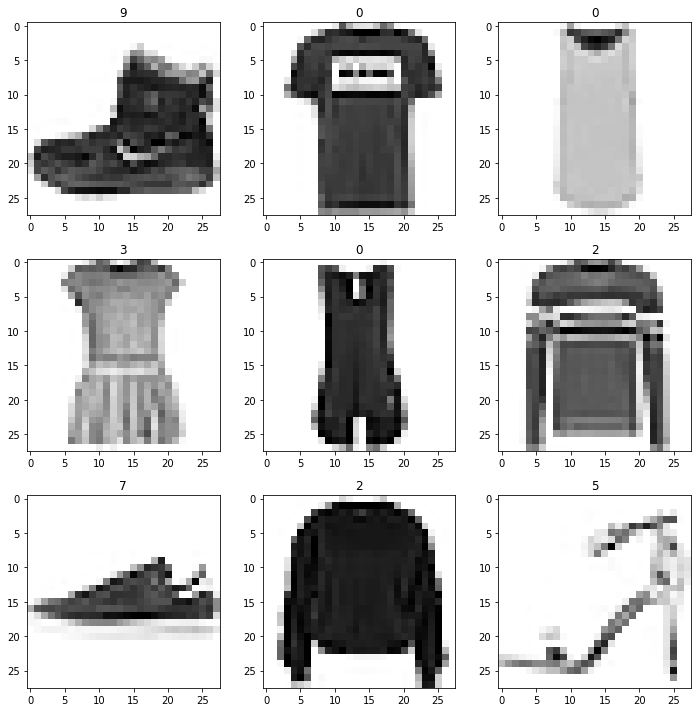

In [ ]:
# Plot some images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[idx], cmap='Greys')
    ax.set_title(y_train[idx])

plt.tight_layout()
plt.show()

The class labels might not make much sense since they have been pre-factored, but here they are from the dataset specification:

| Label | Meaning |
| ---- | ---- |
|0|	T-shirt/top |
|1|	Trouser |
|2|	Pullover |
|3|	Dress |
|4|	Coat |
|5|	Sandal |
|6|	Shirt |
|7|	Sneaker |
|8|	Bag |
|9|	Ankle boot |

In [ ]:
# One hot encode y_train, y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Reshape so 1 image is one sample
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
# Finally scale to (0, 1)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [ ]:
model = keras.Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
	    Dense(100, activation='relu'),
	    Dense(10, activation='softmax')
    ]
)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               160100    
_________________________________________________________________
dense_77 (Dense)             (None, 10)              

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5, 
                    batch_size=100,
                    verbose=1, 
                    validation_split=0.)

480/480 [==============================] - 42s 86ms/step - loss: 0.5686 - accuracy: 0.7973 - val_loss: 0.4071 - val_accuracy: 0.8556


As before, let's check out the historical data:

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.568636,0.797333,0.407143,0.855583,0.001


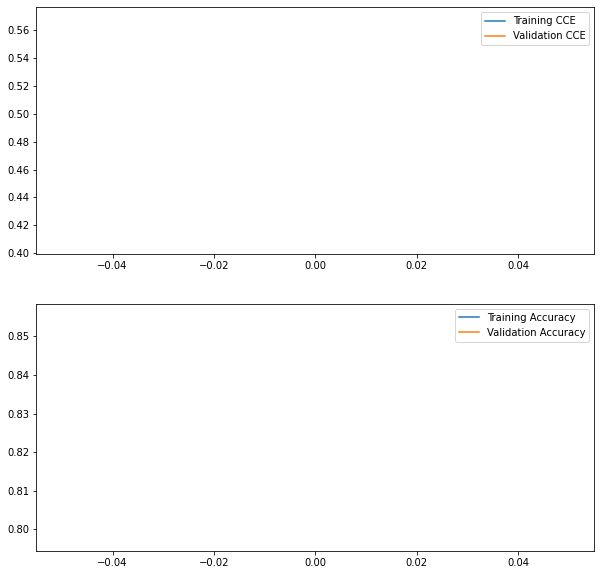

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history_df['loss'], label="Training CCE")
ax1.plot(history_df['val_loss'], label='Validation CCE')
ax1.legend()

ax2.plot(history_df['accuracy'], label="Training Accuracy")
ax2.plot(history_df['val_accuracy'], label="Validation Accuracy")
ax2.legend()

plt.show()

In [ ]:
y_predict = model.predict(x_test)

# Let's take a look at y_predict
print(y_predict[0])

# Argmax along the rows
y_predict = np.argmax(y_predict, axis=1)
y_test = np.argmax(y_test, axis=1)

print(y_predict[0])
# Here we use mean absolute error to get an intepretable value.
print("F1 Score:", f1_score(y_predict, y_test, average='macro'))

[1.3463508e-04 3.7318148e-06 1.3289032e-05 2.4937190e-05 7.3905903e-05
 2.1110097e-02 4.0555489e-05 8.7404765e-02 4.7426182e-03 8.8645148e-01]
9
F1 Score: 0.8452614579563951


# Activity 1.1

It's the last time we're going to use our good friend, the `iris` dataset - but deep learning has so many things that can go wrong, if we have a familiar dataset it can be very helpful! Build a fully connected deep learning model for predicting the species of a iris plant given its attributes. Perform proper scaling, train/test splitting, and find the best metric to use to measure performance (hint: this is a classification task so mean squared error won't work!).

# Activity 1.2

An alternative to the Fashion MNIST dataset is the Digit MNIST dataset which we have seen from another example. Your task is to load the dataset using the function below, and using a CNN build a classifier for judging the digit of an input using proper model validation, scaling and metrics.

Then, try creating an image yourself to test the model out! You will need to use Microsoft Paint (or equivilent) and ensure the size of the image is correct with the input! 

In [ ]:
# The function below will load the dataset.
# For information about the dataset, go to the url below:
# https://keras.io/api/datasets/mnist/
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


# Activity 1.3 (VERY TOUGH!)

Remember the [Birmingham Car Parking dataset](https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham)? Download this dataset and compare the model performance between a fully connected network and a recurrent network for predicting the next car park spaces reading. Some notes to help out (this is a very hard task!)

* You will need to preprocess the data so that you have an array of windows (say hours 1am, 2am, 3am, 4am) and an array of "next hours" (5am for the example above). Note that we know the value of 5am - this is essential for training but we can also shift the window by one and use  that value as an *input* for the next training step (for 6am).
* You have many car parking locations in the dataset - you have two choices, either use the car parking location as another input to your model (you will need to factor that so it is numeric), or treat all car parks in Birmingham as the same and create one large aggregate dataset. Can you think of the pros/cons of each method?

